# Exploratory Data Analysis - EMNIST Balanced

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import collections

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
train = pd.read_csv('data/emnist-balanced-train.csv', header=None, dtype=np.uint8).values
test = pd.read_csv('data/emnist-balanced-test.csv', header=None, dtype=np.uint8).values

X_train = train[:, 1:].astype(np.uint8, copy=False)
X_test = test[:, 1:].astype(np.uint8, copy=False)
y_train = train[:, 0].flatten().astype(np.uint8, copy=False)
y_test = test[:, 0].flatten().astype(np.uint8, copy=False)

# Reshape from (N, 784) to (N, 28, 28)
X_train = X_train.reshape(-1, 28, 28).astype(np.uint8, copy=False)
X_test = X_test.reshape(-1, 28, 28).astype(np.uint8, copy=False)

# Rotate images to correct orientation
X_train = np.fliplr(np.rot90(X_train, k=3, axes=(1, 2))).astype(np.uint8, copy=False)
X_test = np.fliplr(np.rot90(X_test, k=3, axes=(1, 2))).astype(np.uint8, copy=False)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Pixel value range: {X_train.min()} to {X_train.max()}")
print(f"Label value range: {y_train.min()} to {y_train.max()}")

Training set shape: (112800, 28, 28)
Test set shape: (18800, 28, 28)
Training labels shape: (112800,)
Test labels shape: (18800,)
Pixel value range: 0 to 255
Label value range: 0 to 46


In [3]:
mapping_path = 'data/emnist-balanced-mapping.txt'
mapping_df = pd.read_csv(mapping_path, sep='\s+', header=None, names=['label', 'ascii'])
mapping_df = mapping_df.sort_values('label')
class_mapping = {int(row.label): chr(int(row.ascii)) for _, row in mapping_df.iterrows()}

print(f"Total classes: {len(class_mapping)}")
print(f"Class mapping: {class_mapping}")

Total classes: 47
Class mapping: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


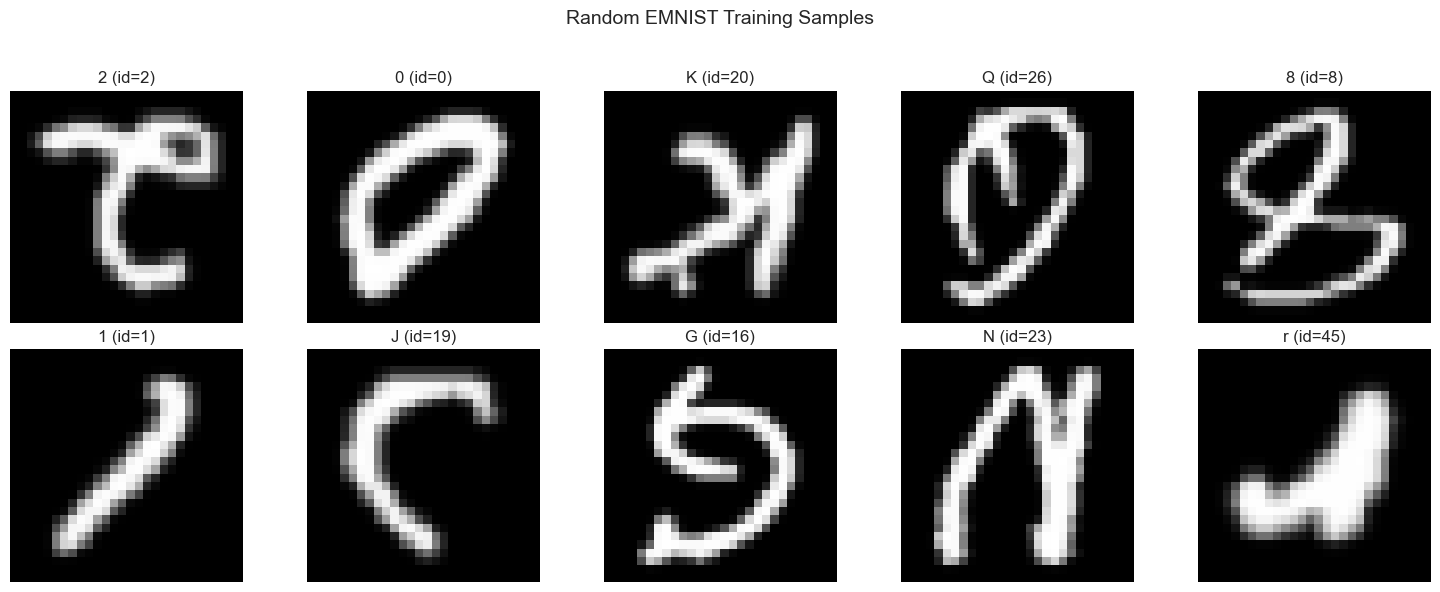

In [4]:
rng = np.random.default_rng()
indices = rng.choice(X_train.shape[0], size=10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, idx in zip(axes.flatten(), indices):
    ax.imshow(X_train[idx], cmap='gray')
    label = class_mapping.get(int(y_train[idx]), int(y_train[idx]))
    ax.set_title(f"{label} (id={int(y_train[idx])})")
    ax.axis('off')

plt.suptitle("Random EMNIST Training Samples", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [5]:
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

train_df = pd.DataFrame(list(train_counts.items()), columns=['class_id', 'count'])
train_df['class_name'] = train_df['class_id'].map(class_mapping)

test_df = pd.DataFrame(list(test_counts.items()), columns=['class_id', 'count'])
test_df['class_name'] = test_df['class_id'].map(class_mapping)

print("Training set class distribution:")
for class_id in sorted(train_counts.keys()):
    class_name = class_mapping.get(class_id, f"Unknown ({class_id})")
    print(f"    {class_name}: {train_counts[class_id]:,}")

print("\nTest set class distribution:")
for class_id in sorted(test_counts.keys()):
    class_name = class_mapping.get(class_id, f"Unknown ({class_id})")
    print(f"    {class_name}: {test_counts[class_id]:,}")

Training set class distribution:
    0: 2,400
    1: 2,400
    2: 2,400
    3: 2,400
    4: 2,400
    5: 2,400
    6: 2,400
    7: 2,400
    8: 2,400
    9: 2,400
    A: 2,400
    B: 2,400
    C: 2,400
    D: 2,400
    E: 2,400
    F: 2,400
    G: 2,400
    H: 2,400
    I: 2,400
    J: 2,400
    K: 2,400
    L: 2,400
    M: 2,400
    N: 2,400
    O: 2,400
    P: 2,400
    Q: 2,400
    R: 2,400
    S: 2,400
    T: 2,400
    U: 2,400
    V: 2,400
    W: 2,400
    X: 2,400
    Y: 2,400
    Z: 2,400
    a: 2,400
    b: 2,400
    d: 2,400
    e: 2,400
    f: 2,400
    g: 2,400
    h: 2,400
    n: 2,400
    q: 2,400
    r: 2,400
    t: 2,400

Test set class distribution:
    0: 400
    1: 400
    2: 400
    3: 400
    4: 400
    5: 400
    6: 400
    7: 400
    8: 400
    9: 400
    A: 400
    B: 400
    C: 400
    D: 400
    E: 400
    F: 400
    G: 400
    H: 400
    I: 400
    J: 400
    K: 400
    L: 400
    M: 400
    N: 400
    O: 400
    P: 400
    Q: 400
    R: 400
    S: 400
    T: 

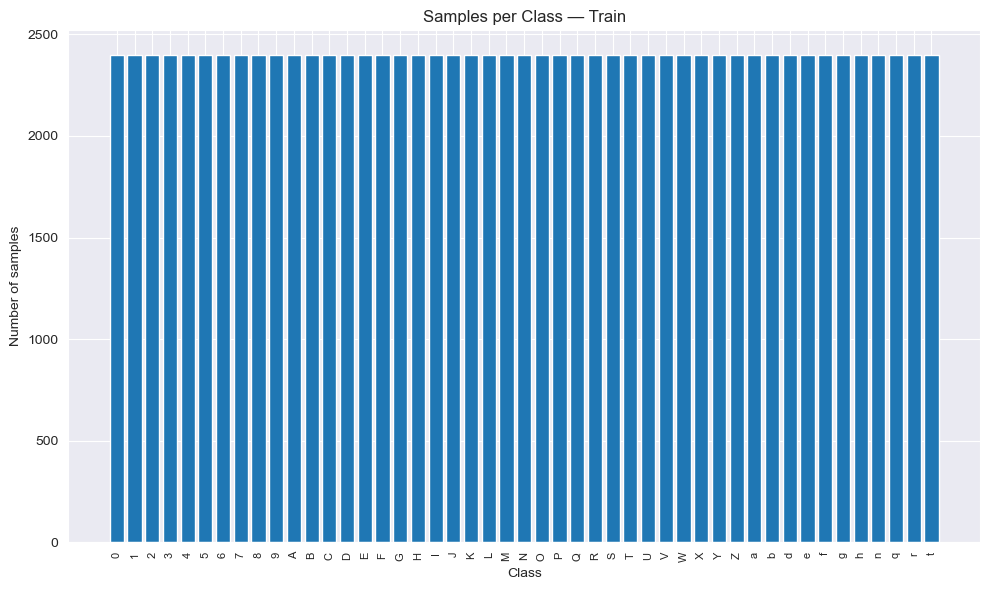

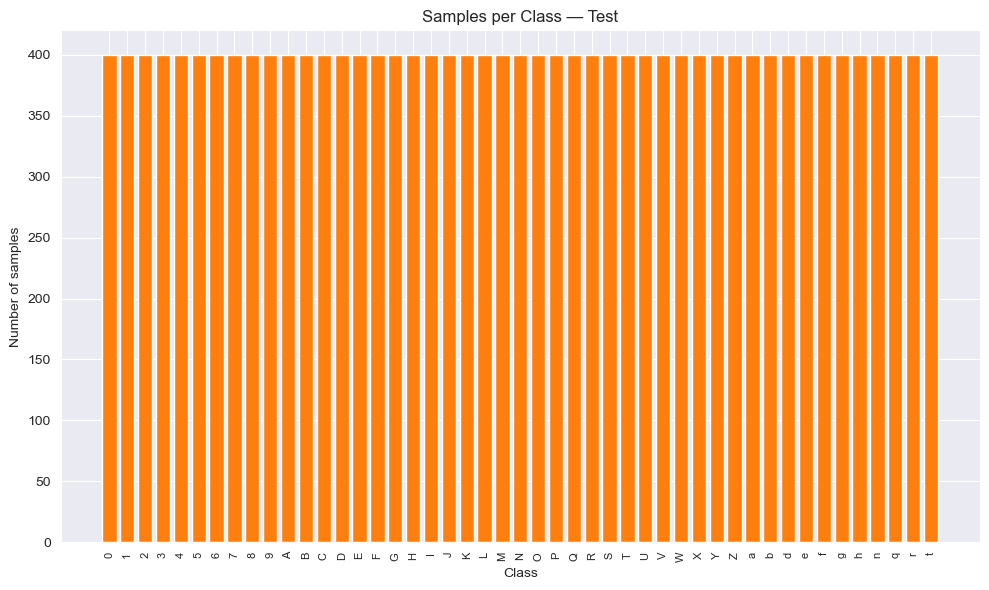

In [6]:
class_ids = sorted(class_mapping.keys())

train_series = pd.Series(train_counts).reindex(class_ids, fill_value=0)
test_series = pd.Series(test_counts).reindex(class_ids, fill_value=0)
class_names = [class_mapping[cid] for cid in class_ids]

plt.figure(figsize=(10, 6))
plt.bar(range(len(class_ids)), train_series.values, color='tab:blue')
plt.xticks(range(len(class_ids)), class_names, rotation=90, fontsize=8)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Samples per Class — Train')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(len(class_ids)), test_series.values, color='tab:orange')
plt.xticks(range(len(class_ids)), class_names, rotation=90, fontsize=8)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Samples per Class — Test')
plt.tight_layout()
plt.show()

In [7]:
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Total samples: {X_train.shape[0] + X_test.shape[0]:,}")
print(f"Image dimensions: {X_train.shape[1]} x {X_train.shape[2]} pixels")
print(f"Number of classes: {len(np.unique(y_train))}")

Training samples: 112,800
Test samples: 18,800
Total samples: 131,600
Image dimensions: 28 x 28 pixels
Number of classes: 47
